# XGBoost on FPI Data

### Importing Necessary Data

In [2]:
import sys
from pathlib import Path
import pandas as pd

# Define the path to src
src_path = Path("/Users/elliotdable/Documents/PhD/research/fpi_ml/src")

# Add src to sys.path
sys.path.append(str(src_path))

# Import the functions
from load_data import madrigal_fpi_loader, prep_ml_dataset, load_imf_data, load_madrigal_imf

%load_ext autoreload
%autoreload 2

In [3]:
madrigal_dir = "/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/madrigal"
imf_dir = '/Users/elliotdable/Documents/PhD/research/fpi_ml/data/imf_data'
zonal_winds, meridional_winds, temps = load_madrigal_imf(madrigal_dir=madrigal_dir, imf_dir=imf_dir)

/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/madrigal/millstone_hill
5792 files found.
/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/madrigal/caocheira_paulista
3351 files found.
/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/madrigal/arecibo
2279 files found.
/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/madrigal/ccore
1121 files found.
Lengths before merge:
ZW: 380714, MW: 386078, TEMPS: 966082, IMF: 2487165
Lengths after merge:
ZW: 350091, MW: 355113, TEMPS: 889094


If want to train on just storm time values, use below cell, and skip the next one:

In [4]:
temps[temps['site_name'] == 'caocheira_paulista'][['geodetic_latitude', 'geodetic_longitude']]

,geodetic_latitude,geodetic_longitude
23615,-20.864229,-45.009290
23616,-22.699362,-45.009290
23617,-20.864229,-45.009290
23619,-22.687142,-43.031523
23701,-22.687142,-43.031523
...,...,...
947375,-22.699362,-45.009290
947377,-20.864229,-45.009290
947378,-22.687142,-43.031523
947379,-24.533817,-45.009290


In [ ]:
'''temps_storm = (temps[temps['dst'] < -50])
zonal_winds_storm= (zonal_winds[zonal_winds['dst'] < -50])
meridional_winds_storm = (meridional_winds[meridional_winds['dst'] < -50])

temps_limited = temps_storm[(temps_storm.temperature < 1800) & (temps_storm.temperature > 450) & (temps_storm.year != 2024)].dropna()
zw_limited = zonal_winds_storm[(abs(zonal_winds_storm.zonal_wind_speed) < 1000) & (zonal_winds_storm.year != 2024)].dropna()
mw_limited = meridional_winds_storm[(abs(meridional_winds_storm.meridional_wind_speed) < 1000) & (meridional_winds_storm.year != 2024)].dropna()'''

skip if using storm

In [5]:
temps_limited = temps[(temps.temperature < 1800) & (temps.temperature > 450) & (temps.year != 2024)].dropna()
zw_limited = zonal_winds[(abs(zonal_winds.zonal_wind_speed) < 1000) & (zonal_winds.year != 2024)].dropna()
mw_limited = meridional_winds[(abs(meridional_winds.meridional_wind_speed) < 1000) & (meridional_winds.year != 2024)].dropna()

In [6]:
temps_limited.columns

Index(['datetime', 'year', 'month', 'day', 'hour', 'solar_local_time',
       'hour_local', 'magnetic_local_time', 'site_name', 'min_altitude',
       'max_altitude', 'geodetic_altitude', 'elevation_angle',
       'geodetic_latitude', 'geodetic_longitude', 'solar_zenith_angle', 'kp',
       'dst', 'f10.7', 'multiday_f10.7', 'ap_3_hour', 'ap_daily',
       'temperature', 'temperature_error', 'bt', 'bx_gse', 'by_gse', 'bz_gse',
       'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm',
       'phi_gsm'],
      dtype='object')

In [7]:
params = ['year', 'month', 'day', 'hour',
        'geodetic_latitude', 'geodetic_longitude', 'solar_zenith_angle', 'kp',
        'dst', 'f10.7','ap_3_hour', 'bx_gse', 'by_gse', 'bz_gse']
zonal_winds_params, zonal_winds_target, meridional_winds_params, meridional_winds_target, temps_params, temps_target = prep_ml_dataset(zw_limited, mw_limited, temps_limited, params)

In [8]:
temps_params.shape, temps_target.shape, zonal_winds_params.shape, zonal_winds_target.shape, meridional_winds_params.shape, meridional_winds_target.shape

((634123, 14),
 (634123, 1),
 (305488, 14),
 (305488, 1),
 (310267, 14),
 (310267, 1))

## Quick Analysis

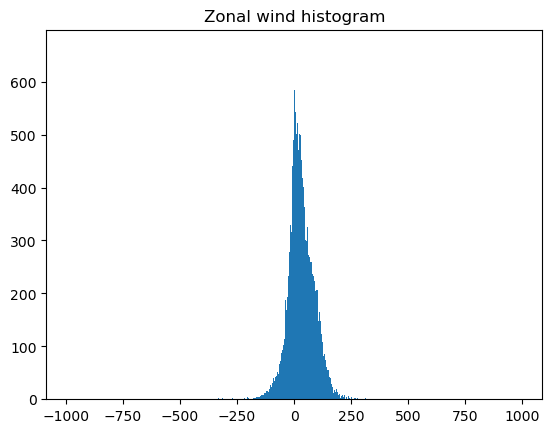

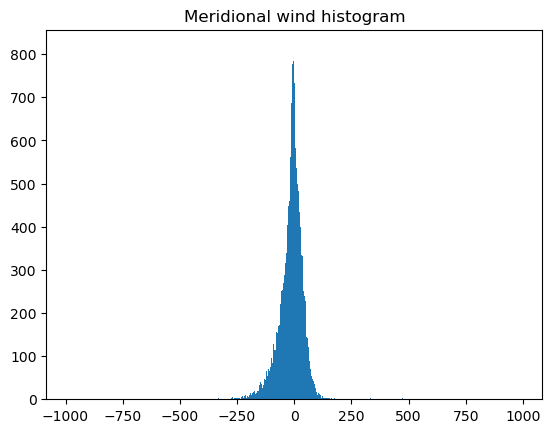

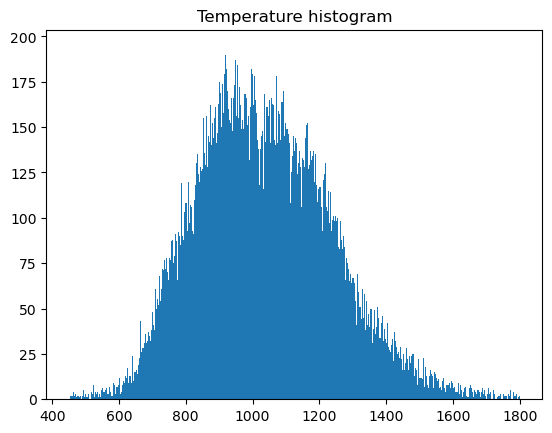

In [9]:
import matplotlib.pyplot as plt

plt.hist(zonal_winds_target.zonal_wind_speed, bins=10000)
plt.title('Zonal wind histogram')
plt.show()
plt.hist(meridional_winds_target.meridional_wind_speed, bins=10000)
plt.title('Meridional wind histogram')
plt.show()
plt.hist(temps_target.temperature, bins=10000)
plt.title('Temperature histogram')
plt.show()

## XGBoost Routine

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
import xgboost as xgb

# Splitting into training and testing zonal_windssets
X_train, X_test, y_train, y_test = train_test_split(zonal_winds_params, zonal_winds_target, test_size=0.2, random_state=42)

In [12]:
def plot_learning_curve(X_train, y_train, X_test, y_test, xgb_params):
    train_errors = []
    test_errors = []
    data_sizes = np.linspace(0.1, 1.0, 10)  # Fraction of data used for training

    for size in data_sizes:
        # Sample a fraction of the training data
        n_train = int(size * len(X_train))
        X_train_sample = X_train[:n_train]
        y_train_sample = y_train[:n_train]

        # Train the model
        xgb_model = xgb.XGBRegressor(**xgb_params)
        xgb_model.fit(X_train_sample, y_train_sample)

        # Evaluate on training and testing data
        train_pred = xgb_model.predict(X_train_sample)
        test_pred = xgb_model.predict(X_test)
        
        train_errors.append(root_mean_squared_error(y_train_sample, train_pred))
        test_errors.append(root_mean_squared_error(y_test, test_pred))

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(data_sizes, train_errors, label='Training Error', marker='o')
    plt.plot(data_sizes, test_errors, label='Validation Error', marker='o')
    plt.title('Learning Curve')
    plt.xlabel('Fraction of Training Data')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    xgb.plot_importance(xgb_model)
    plt.show()

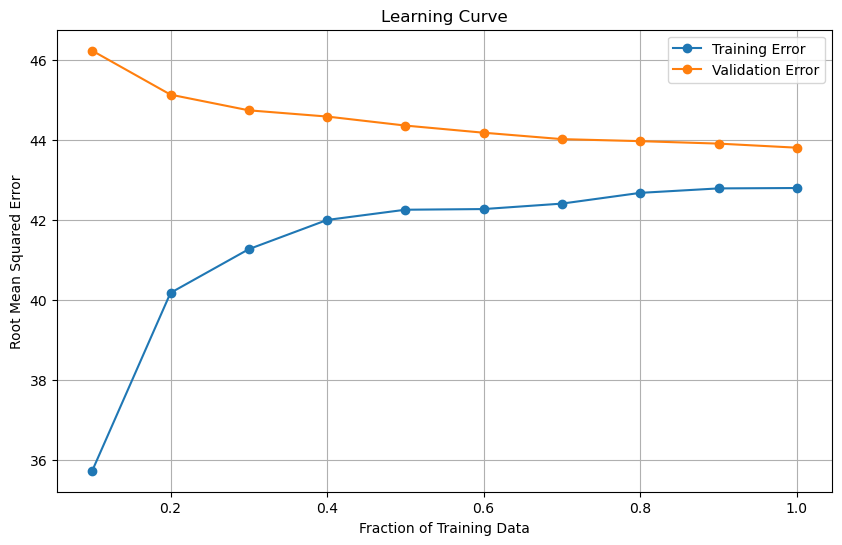

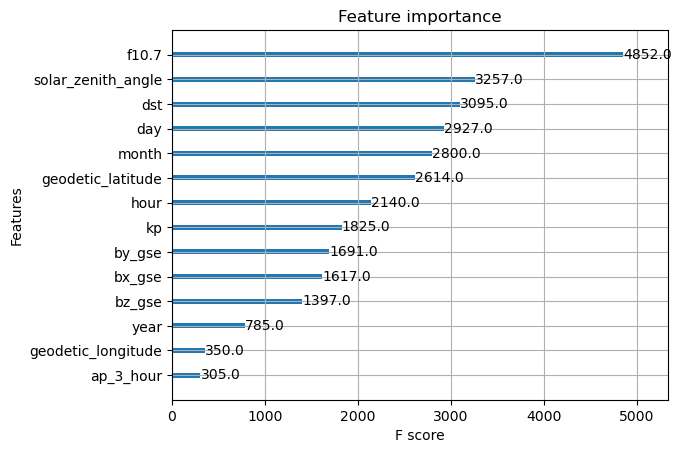

In [13]:
# XGBoost Parameters
xgb_params = {
    'objective': 'reg:squarederror',  # For regression task
    'n_estimators': 2000,             # Increase the number of trees (compensate for lower learning rate)
    'learning_rate': 0.05,             # Lower learning rate for finer optimization
    'max_depth': 4,                   # Shallower trees to reduce overfitting
    'subsample': 0.9,                 # Use more data per tree
    'colsample_bytree': 0.9,          # Use more features per tree
    'random_state': 42,               # For reproducibility
    'alpha': 1.0,                     # L1 regularization
    'lambda': 1.0,                    # L2 regularization
    'min_child_weight': 3,            # Minimum child weight for leaf nodes
    'gamma': 1.0,                     # Minimum loss reduction required to make a further partition
}

plot_learning_curve(X_train, y_train, X_test, y_test, xgb_params)

### MSIS

In [14]:
import numpy as np
from pymsis import msis, utils

def run_msis_specific_location(start_date, end_date, lat, lon, alt):

    date_range = pd.date_range(start=start_date, end=end_date, freq='10T')

    f107, f107a, aps = utils.get_f107_ap(date_range)
    data = msis.run(date_range, lat, lon, alt, aps=aps, f107s=f107, f107as=f107a, geomagnetic_activity=-1, version=2.1)

    data = data.squeeze()
    data = pd.DataFrame(data)

    data = data.rename(columns={
    0: 'msis_mass_density',
    1: 'n2_density',
    2: 'o2_density',
    3: 'o_density',
    4: 'he_density',
    5: 'h_density',
    6: 'ar_density',
    7: 'n_density',
    8: 'anomalous_o_density',
    9: 'no_density',   
    10: 'msis_temperature'})

    data['datetime'] = date_range.values
    return data

#Define a function to lookup temperature based on the datetime match
def get_temperature_from_temps(row, temps_df, datetime_col):
    matching_row = temps_df.loc[temps_df[datetime_col] == row['datetime']]
    if not matching_row.empty:
        return matching_row['temperature'].values[0]  # Extract the temperature from the matching row
    else:
        return None  # If no match found, return None or some default value

In [15]:
start_date = "2024-05-10"
end_date = "2024-05-15"

brazil_msis = run_msis_specific_location(start_date, end_date, -22.703764, -45.00929 , 210)
millstone_hill_msis = run_msis_specific_location(start_date, end_date, 42.6, -71.5, 210)

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2844322307.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
/Users/elliotdable/anaconda3/envs/thermosphere_ml/lib/python3.12/site-packages/pymsis/utils.py:45: UserWarning: Downloading ap and F10.7 data from https://celestrak.org/SpaceData/SW-All.csv
  warnings.warn(f"Downloading ap and F10.7 data from {_F107_AP_URL}")
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2844322307.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


### WAM-IPE

In [16]:
wam_ipe_brazil = pd.read_csv('/Users/elliotdable/Documents/PhD/research/transfer_docs/code/data/Brazil_WAMIPE_win_temp_dens.csv')
wam_ipe_brazil['datetime'] = pd.to_datetime(wam_ipe_brazil['Time'])
wam_ipe_brazil = wam_ipe_brazil.drop(columns=['Time'])
wam_ipe_brazil = wam_ipe_brazil.rename(columns={'Density':'density', 'Temperature': 'temperature', 'U_Wind': 'zonal_wind_speed', 'V_Wind': 'meridional_wind_speed'})
wam_ipe_brazil['density'] = wam_ipe_brazil['density'].str.strip('[]').astype(float)
wam_ipe_brazil['density'] = wam_ipe_brazil['density'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_brazil['temperature'] = wam_ipe_brazil['temperature'].str.strip('[]').astype(float)
wam_ipe_brazil['temperature'] = wam_ipe_brazil['temperature'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_brazil['zonal_wind_speed'] = wam_ipe_brazil['zonal_wind_speed'].str.strip('[]').astype(float)
wam_ipe_brazil['zonal_wind_speed'] = wam_ipe_brazil['zonal_wind_speed'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_brazil['meridional_wind_speed'] = wam_ipe_brazil['meridional_wind_speed'].str.strip('[]').astype(float)
wam_ipe_brazil['meridional_wind_speed'] = wam_ipe_brazil['meridional_wind_speed'].apply(lambda x: x[0] if isinstance(x, list) else x)

wam_ipe_millstone_hill = pd.read_csv('/Users/elliotdable/Documents/PhD/research/transfer_docs/code/data/Millstone_Hill_WAMIPE_win_temp_dens.csv')
wam_ipe_millstone_hill['datetime'] = pd.to_datetime(wam_ipe_millstone_hill['Time'])
wam_ipe_millstone_hill = wam_ipe_millstone_hill.drop(columns=['Time'])
wam_ipe_millstone_hill = wam_ipe_millstone_hill.rename(columns={'Density':'density', 'Temperature': 'temperature', 'U_Wind': 'zonal_wind_speed', 'V_Wind': 'meridional_wind_speed'})
wam_ipe_millstone_hill['density'] = wam_ipe_millstone_hill['density'].str.strip('[]').astype(float)
wam_ipe_millstone_hill['density'] = wam_ipe_millstone_hill['density'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_millstone_hill['temperature'] = wam_ipe_millstone_hill['temperature'].str.strip('[]').astype(float)
wam_ipe_millstone_hill['temperature'] = wam_ipe_millstone_hill['temperature'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_millstone_hill['zonal_wind_speed'] = wam_ipe_millstone_hill['zonal_wind_speed'].str.strip('[]').astype(float)
wam_ipe_millstone_hill['zonal_wind_speed'] = wam_ipe_millstone_hill['zonal_wind_speed'].apply(lambda x: x[0] if isinstance(x, list) else x)
wam_ipe_millstone_hill['meridional_wind_speed'] = wam_ipe_millstone_hill['meridional_wind_speed'].str.strip('[]').astype(float)
wam_ipe_millstone_hill['meridional_wind_speed'] = wam_ipe_millstone_hill['meridional_wind_speed'].apply(lambda x: x[0] if isinstance(x, list) else x)


### Training a Specific Temperature Model

In [17]:
import numpy as np

# Splitting into training and testing tempssets
X_train, X_test, y_train, y_test = train_test_split(temps_params, temps_target, test_size=0.2, random_state=42)

xgb_params = {
    'objective': 'reg:squarederror',  # For regression task
    'n_estimators': 5000,             # Increase the number of trees (compensate for lower learning rate)
    'learning_rate': 0.05,             # Lower learning rate for finer optimization
    'max_depth': 5,                   # Shallower trees to reduce overfitting
    'subsample': 0.9,                 # Use more data per tree
    'colsample_bytree': 0.9,          # Use more features per tree
    'random_state': 42,               # For reproducibility
    'alpha': 1,                         # L1 regularization
    'lambda': 1,                        # L2 regularization
    'min_child_weight': 5             # Minimum child weight for leaf nodes
}

[0]	validation_0-rmse:199.43848	validation_1-rmse:198.91613
[1]	validation_0-rmse:194.68909	validation_1-rmse:194.12166
[2]	validation_0-rmse:190.27987	validation_1-rmse:189.68210
[3]	validation_0-rmse:186.12580	validation_1-rmse:185.48787
[4]	validation_0-rmse:182.18127	validation_1-rmse:181.50807
[5]	validation_0-rmse:178.67500	validation_1-rmse:177.98246
[6]	validation_0-rmse:175.27593	validation_1-rmse:174.55963
[7]	validation_0-rmse:172.20106	validation_1-rmse:171.46380
[8]	validation_0-rmse:169.28923	validation_1-rmse:168.55300
[9]	validation_0-rmse:166.60580	validation_1-rmse:165.84162
[10]	validation_0-rmse:164.13091	validation_1-rmse:163.34765
[11]	validation_0-rmse:161.73848	validation_1-rmse:160.93737
[12]	validation_0-rmse:159.45065	validation_1-rmse:158.64652
[13]	validation_0-rmse:157.31575	validation_1-rmse:156.50378
[14]	validation_0-rmse:155.42843	validation_1-rmse:154.60954
[15]	validation_0-rmse:153.50664	validation_1-rmse:152.67029
[16]	validation_0-rmse:151.58977	v

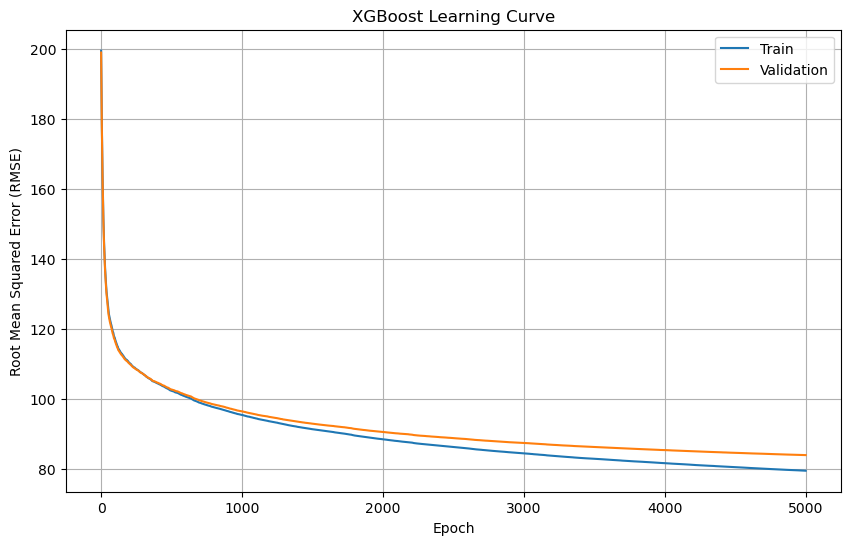

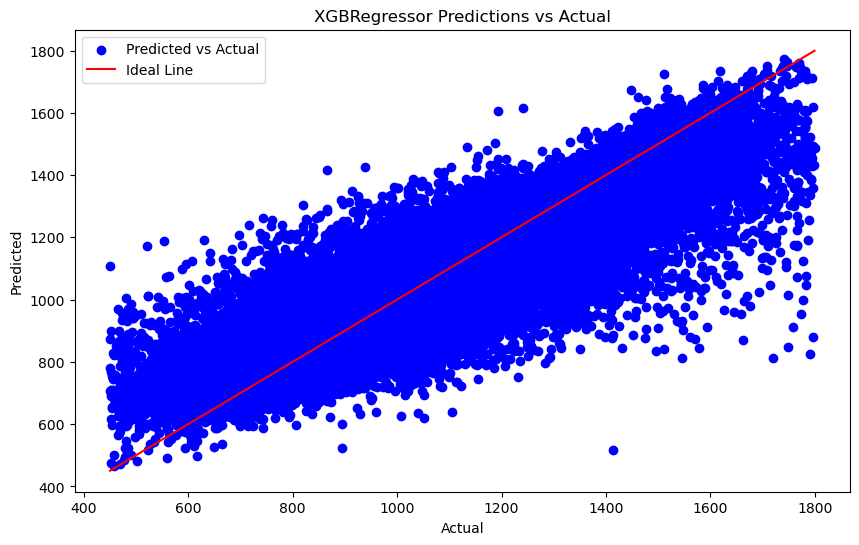

In [18]:
# Initialize XGBRegressor
model = xgb.XGBRegressor(**xgb_params)

# Train the model using the training data with evaluation set for learning curve
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate and print Root Mean Squared Error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Extract learning curve data
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.title('XGBoost Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.temperature, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test.temperature), max(y_test.temperature)], [min(y_test.temperature), max(y_test.temperature)], color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBRegressor Predictions vs Actual')
plt.legend()
plt.show()

In [19]:
temps_may_2024 = temps[(temps.datetime >= '2024-05-10') & (temps.datetime < '2024-05-15') & (temps.temperature > 800)]
temps_may_2024 = temps_may_2024.sort_values('datetime')
temps_may_2024 = temps_may_2024[['datetime', 'site_name'] + params + ['temperature', 'temperature_error']]
temps_may_2024_cp = temps_may_2024[temps_may_2024['site_name']=='caocheira_paulista']
temps_may_2024_mh = temps_may_2024[temps_may_2024['site_name']=='millstone_hill']

In [22]:
predicted_temp_cp = model.predict(temps_may_2024_cp[params])
predicted_temp_cp = pd.DataFrame({'datetime': temps_may_2024_cp['datetime'], 'temperature': predicted_temp_cp})

temps_may_2024_cp['time_diff'] = temps_may_2024_cp['datetime'].diff()
temps_may_2024_cp.loc[temps_may_2024_cp['time_diff'] > pd.Timedelta(minutes=60), 'temperature'] = np.nan
temps_may_2024_cp['rolling_avg'] = temps_may_2024_cp['temperature'].rolling(window=10).mean()

predicted_temp_cp['time_diff'] = predicted_temp_cp['datetime'].diff()
predicted_temp_cp.loc[predicted_temp_cp['time_diff'] > pd.Timedelta(minutes=60), 'temperature'] = np.nan
predicted_temp_cp['rolling_avg'] = predicted_temp_cp['temperature'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2057576571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_cp['time_diff'] = temps_may_2024_cp['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2057576571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_cp['rolling_avg'] = temps_may_2024_cp['temperature'].rolling(window=10).mean()


In [23]:
predicted_temp_mh = model.predict(temps_may_2024_mh[params])
predicted_temp_mh = pd.DataFrame({'datetime': temps_may_2024_mh['datetime'], 'temperature': predicted_temp_mh})

temps_may_2024_mh['time_diff'] = temps_may_2024_mh['datetime'].diff()
temps_may_2024_mh.loc[temps_may_2024_mh['time_diff'] > pd.Timedelta(minutes=60), 'temperature'] = np.nan
temps_may_2024_mh['rolling_avg'] = temps_may_2024_mh['temperature'].rolling(window=10).mean()

predicted_temp_mh['time_diff'] = predicted_temp_mh['datetime'].diff()
predicted_temp_mh.loc[predicted_temp_mh['time_diff'] > pd.Timedelta(minutes=60), 'temperature'] = np.nan
predicted_temp_mh['rolling_avg'] = predicted_temp_mh['temperature'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/1920055257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_mh['time_diff'] = temps_may_2024_mh['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/1920055257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_mh['rolling_avg'] = temps_may_2024_mh['temperature'].rolling(window=10).mean()


In [24]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime

# Convert the 'datetime' column to datetime type
temps_may_2024_cp['datetime'] = pd.to_datetime(temps_may_2024_cp['datetime'], format="%d/%m %H")
predicted_temp_cp['datetime'] = pd.to_datetime(predicted_temp_cp['datetime'], format="%d/%m %H")

# Convert the 'datetime' column to datetime type
temps_may_2024_mh['datetime'] = pd.to_datetime(temps_may_2024_mh['datetime'], format="%d/%m %H")
predicted_temp_mh['datetime'] = pd.to_datetime(predicted_temp_mh['datetime'], format="%d/%m %H")

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2156068053.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_cp['datetime'] = pd.to_datetime(temps_may_2024_cp['datetime'], format="%d/%m %H")
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2156068053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_mh['datetime'] = pd.to_datetime(temps_may_2024_mh['datetime'], format="%d/%m %H")


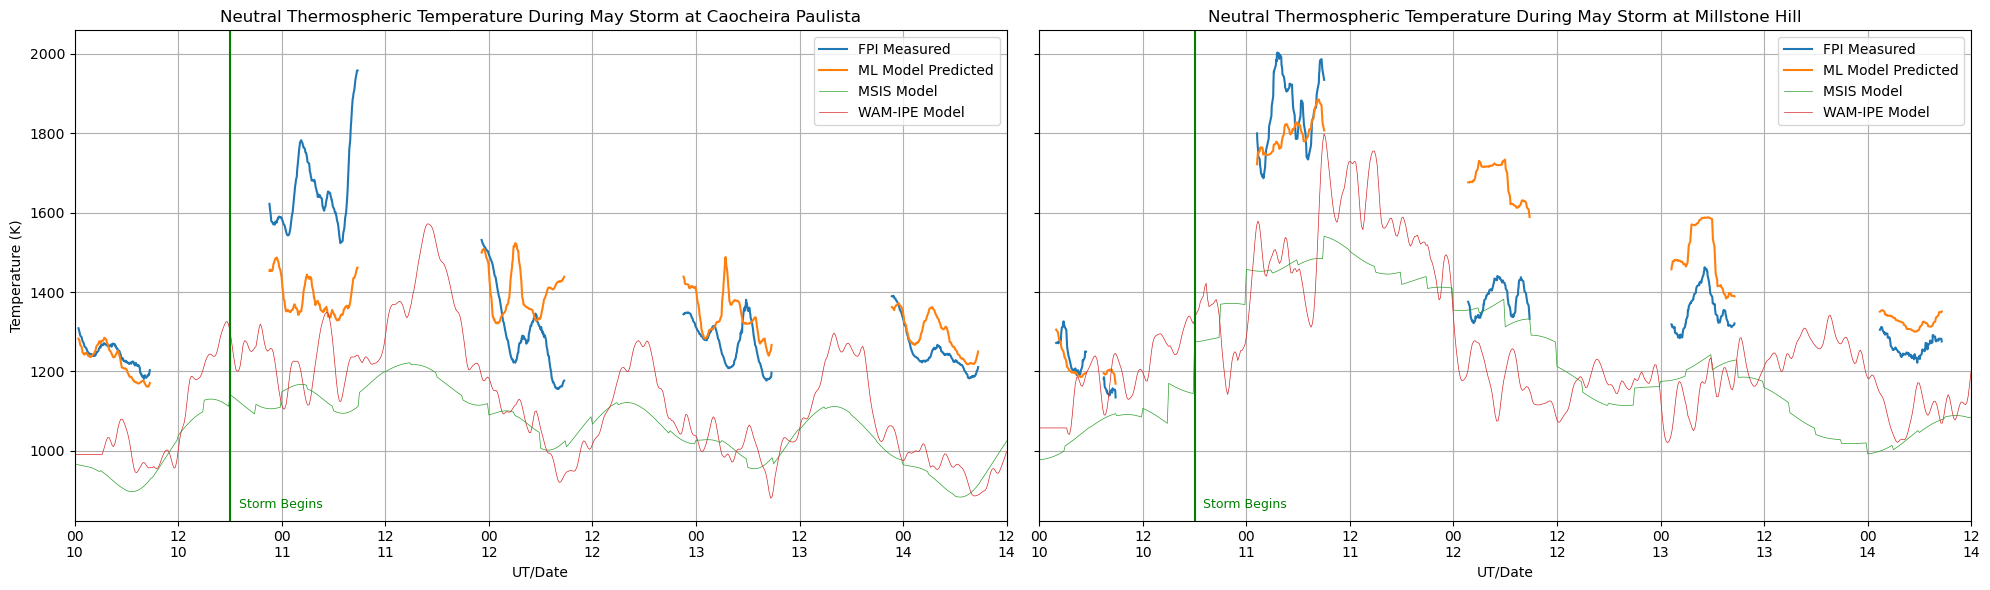

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(temps_may_2024_cp['datetime'], temps_may_2024_cp['rolling_avg'], label='FPI Measured')
ax1.plot(predicted_temp_cp['datetime'], predicted_temp_cp['rolling_avg'], label='ML Model Predicted')
ax1.plot(brazil_msis['datetime'], brazil_msis['msis_temperature'], label='MSIS Model', linewidth=0.5)
ax1.plot(wam_ipe_brazil['datetime'], wam_ipe_brazil['temperature'], label='WAM-IPE Model', linewidth=0.5)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.set_title('Neutral Thermospheric Temperature During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(temps_may_2024_mh['datetime'], temps_may_2024_mh['rolling_avg'], label='FPI Measured')
ax2.plot(predicted_temp_mh['datetime'], predicted_temp_mh['rolling_avg'], label='ML Model Predicted')
ax2.plot(millstone_hill_msis['datetime'], millstone_hill_msis['msis_temperature'], label='MSIS Model', linewidth=0.5)
ax2.plot(wam_ipe_millstone_hill['datetime'], wam_ipe_millstone_hill['temperature'], label='WAM-IPE Model', linewidth=0.5)
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.set_title('Neutral Thermospheric Temperature During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# Ensure datetime columns are datetime objects
temps_may_2024_cp['datetime'] = pd.to_datetime(temps_may_2024_cp['datetime'])
wam_ipe_brazil['datetime'] = pd.to_datetime(wam_ipe_brazil['datetime'])

# Create copies to prevent modifying the original DataFrames
temps_copy = temps_may_2024_cp.copy()
wam_ipe_copy = wam_ipe_brazil.copy()

temps_copy = temps_copy.drop_duplicates(subset='datetime')

# Set datetime as the index
temps_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = temps_copy['rolling_avg'][temps_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = temps_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = temps_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'temperature'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = temps_copy.index.union(wam_ipe_copy.index)
temps_resampled = temps_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = abs(100*(wam_ipe_resampled['temperature'] - temps_resampled['rolling_avg'])/temps_resampled['rolling_avg'])

# Create a DataFrame with datetime and difference columns
difference_df_wam_cp = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_wam_cp['datetime'] = pd.to_datetime(difference_df_wam_cp['datetime'])
difference_df_wam_cp['time_diff'] = difference_df_wam_cp['datetime'].diff()
difference_df_wam_cp.loc[difference_df_wam_cp['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_cp = pd.merge(temps_may_2024_cp[['datetime', 'rolling_avg']],
                     predicted_temp_cp[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_cp['difference'] = abs(100*(merged_df_cp['rolling_avg_predicted'] - merged_df_cp['rolling_avg_measured'])/merged_df_cp['rolling_avg_measured'])

brazil_msis['datetime'] = pd.to_datetime(brazil_msis['datetime'])

brazil_msis_copy = brazil_msis.copy()

brazil_msis_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = temps_copy['rolling_avg'][temps_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = temps_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = temps_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in brazil_msis_copy between these times
        mask = (brazil_msis_copy.index > previous_time) & (brazil_msis_copy.index < next_time)
        brazil_msis_copy.loc[mask, 'msis_temperature'] = np.nan

# Ensure DataFrame remains sorted after adding rows
brazil_msis_copy.sort_index(inplace=True)

brazil_msis_resampled = brazil_msis_copy.reindex(common_index).interpolate()

# Calculate the difference
difference_msis =  abs(100*(brazil_msis_resampled['msis_temperature'] - temps_resampled['rolling_avg'])/temps_resampled['rolling_avg'])

# Create a DataFrame with datetime and difference columns
difference_df_msis_cp = pd.DataFrame({
    'datetime': difference_msis.index,
    'difference': difference_msis
})

difference_df_msis_cp['datetime'] = pd.to_datetime(difference_df_msis_cp['datetime'])
difference_df_msis_cp['time_diff'] = difference_df_msis_cp['datetime'].diff()
difference_df_msis_cp.loc[difference_df_msis_cp['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3250885126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_cp['datetime'] = pd.to_datetime(temps_may_2024_cp['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3250885126.py:34: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temps_resampled = temps_copy.reindex(common_index).interpolate()


In [27]:
# Ensure datetime columns are datetime objects
temps_may_2024_mh['datetime'] = pd.to_datetime(temps_may_2024_mh['datetime'])
wam_ipe_millstone_hill['datetime'] = pd.to_datetime(wam_ipe_millstone_hill['datetime'])

# Create copies to prevent modifying the original DataFrames
temps_copy = temps_may_2024_mh.copy()
wam_ipe_copy = wam_ipe_millstone_hill.copy()

temps_copy = temps_copy.drop_duplicates(subset='datetime')

# Set datetime as the index
temps_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = temps_copy['rolling_avg'][temps_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = temps_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = temps_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'temperature'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = temps_copy.index.union(wam_ipe_copy.index)
temps_resampled = temps_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = abs(100*(wam_ipe_resampled['temperature'] - temps_resampled['rolling_avg'])/temps_resampled['rolling_avg'])

# Create a DataFrame with datetime and difference columns
difference_df_wam_mh = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_wam_mh['datetime'] = pd.to_datetime(difference_df_wam_mh['datetime'])
difference_df_wam_mh['time_diff'] = difference_df_wam_mh['datetime'].diff()
difference_df_wam_mh.loc[difference_df_wam_mh['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_mh = pd.merge(temps_may_2024_mh[['datetime', 'rolling_avg']],
                     predicted_temp_mh[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_mh['difference'] = abs(100*(merged_df_mh['rolling_avg_predicted'] - merged_df_mh['rolling_avg_measured'])/merged_df_mh['rolling_avg_measured'])

millstone_hill_msis['datetime'] = pd.to_datetime(millstone_hill_msis['datetime'])

millstone_hill_msis_copy = millstone_hill_msis.copy()

millstone_hill_msis_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = temps_copy['rolling_avg'][temps_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = temps_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = temps_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in millstone_hill_msis_copy between these times
        mask = (millstone_hill_msis_copy.index > previous_time) & (millstone_hill_msis_copy.index < next_time)
        millstone_hill_msis_copy.loc[mask, 'msis_temperature'] = np.nan

# Ensure DataFrame remains sorted after adding rows
millstone_hill_msis_copy.sort_index(inplace=True)

millstone_hill_msis_resampled = millstone_hill_msis_copy.reindex(common_index).interpolate()

# Calculate the difference
difference_msis =  abs(100*(millstone_hill_msis_resampled['msis_temperature'] - temps_resampled['rolling_avg'])/temps_resampled['rolling_avg'])

# Create a DataFrame with datetime and difference columns
difference_df_msis_mh = pd.DataFrame({
    'datetime': difference_msis.index,
    'difference': difference_msis
})

difference_df_msis_mh['datetime'] = pd.to_datetime(difference_df_msis_mh['datetime'])
difference_df_msis_mh['time_diff'] = difference_df_msis_mh['datetime'].diff()
difference_df_msis_mh.loc[difference_df_msis_mh['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3535175228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps_may_2024_mh['datetime'] = pd.to_datetime(temps_may_2024_mh['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3535175228.py:34: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temps_resampled = temps_copy.reindex(common_index).interpolate()


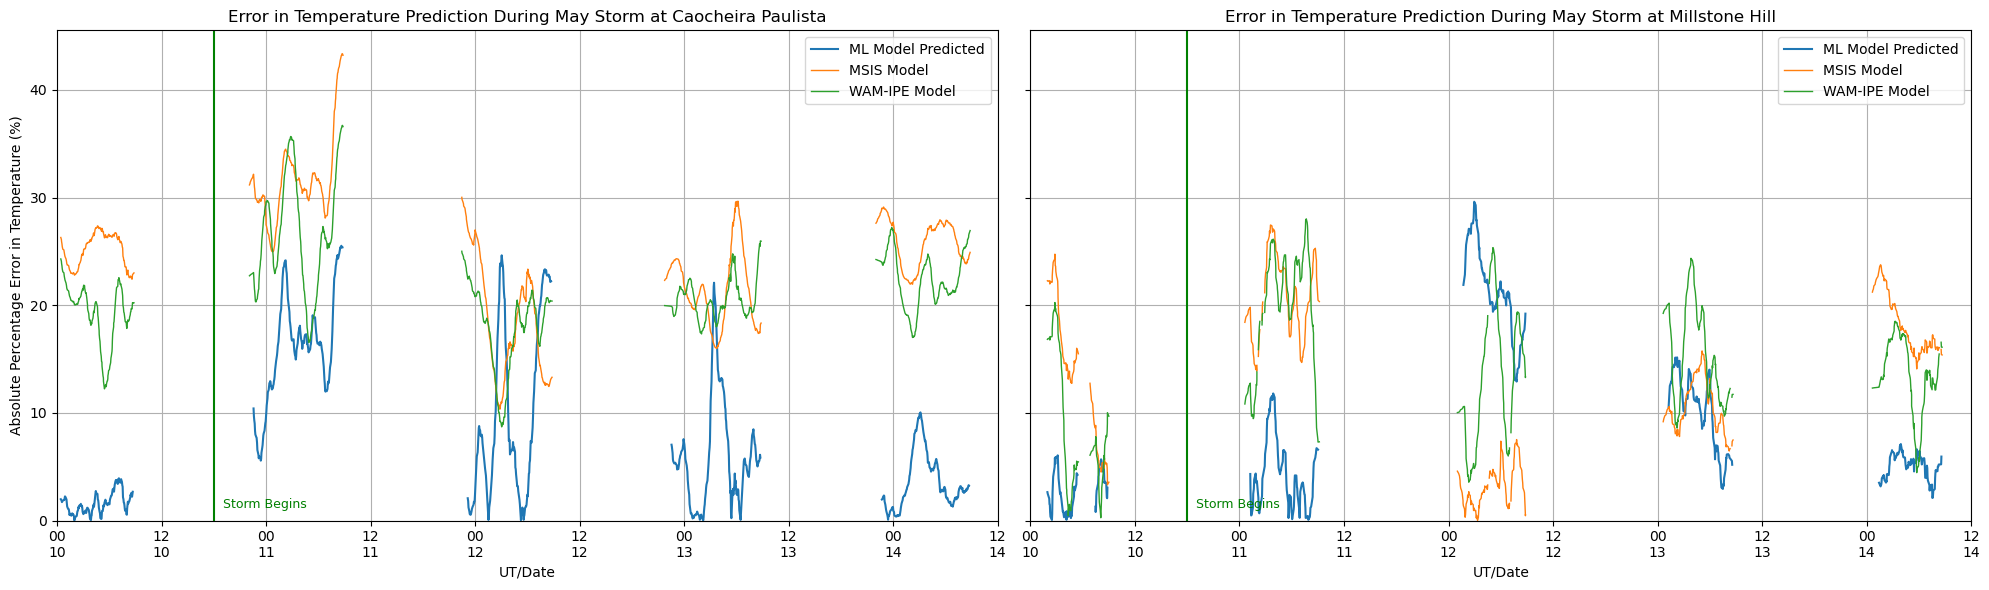

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(merged_df_cp['datetime'], merged_df_cp['difference'], label='ML Model Predicted')
ax1.plot(difference_df_msis_cp['datetime'], difference_df_msis_cp['difference'], label='MSIS Model', linewidth=1)
ax1.plot(difference_df_wam_cp['datetime'], difference_df_wam_cp['difference'], label='WAM-IPE Model', linewidth=1)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Absolute Percentage Error in Temperature (%)')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(0,)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.set_title('Error in Temperature Prediction During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(merged_df_mh['datetime'], merged_df_mh['difference'], label='ML Model Predicted')
ax2.plot(difference_df_msis_mh['datetime'], difference_df_msis_mh['difference'], label='MSIS Model', linewidth=1)
ax2.plot(difference_df_wam_mh['datetime'], difference_df_wam_mh['difference'], label='WAM-IPE Model', linewidth=1)
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.set_title('Error in Temperature Prediction During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Training a Specific Zonal Wind Speed Model

In [ ]:
import numpy as np

# Splitting into training and testing zonal_windssets
X_train, X_test, y_train, y_test = train_test_split(zonal_winds_params, zonal_winds_target, test_size=0.2, random_state=42)

xgb_params = {
    'objective': 'reg:squarederror',  # For regression task
    'n_estimators': 5000,             # Increase the number of trees (compensate for lower learning rate)
    'learning_rate': 0.1,             # Lower learning rate for finer optimization
    'max_depth': 4,                   # Shallower trees to reduce overfitting
    'subsample': 0.9,                 # Use more data per tree
    'colsample_bytree': 0.9,          # Use more features per tree
    'random_state': 42,               # For reproducibility
    'alpha': 1,                     # L1 regularization
    'lambda': 1,                    # L2 regularization
    'min_child_weight': 10            # Minimum child weight for leaf nodes
}

[0]	validation_0-rmse:55.95333	validation_1-rmse:51.24057
[1]	validation_0-rmse:54.60618	validation_1-rmse:49.91977
[2]	validation_0-rmse:53.42342	validation_1-rmse:49.07585
[3]	validation_0-rmse:52.39759	validation_1-rmse:48.38086
[4]	validation_0-rmse:51.41976	validation_1-rmse:47.55750
[5]	validation_0-rmse:50.51700	validation_1-rmse:46.88476
[6]	validation_0-rmse:49.77972	validation_1-rmse:46.60554
[7]	validation_0-rmse:48.97353	validation_1-rmse:46.09412
[8]	validation_0-rmse:48.40355	validation_1-rmse:45.77745
[9]	validation_0-rmse:47.82968	validation_1-rmse:45.35164
[10]	validation_0-rmse:47.14065	validation_1-rmse:44.95216
[11]	validation_0-rmse:46.68444	validation_1-rmse:44.57462
[12]	validation_0-rmse:46.28740	validation_1-rmse:44.33427
[13]	validation_0-rmse:45.83043	validation_1-rmse:43.95506
[14]	validation_0-rmse:45.40911	validation_1-rmse:43.76927
[15]	validation_0-rmse:44.94592	validation_1-rmse:43.46030
[16]	validation_0-rmse:44.65069	validation_1-rmse:43.35256
[17]	va

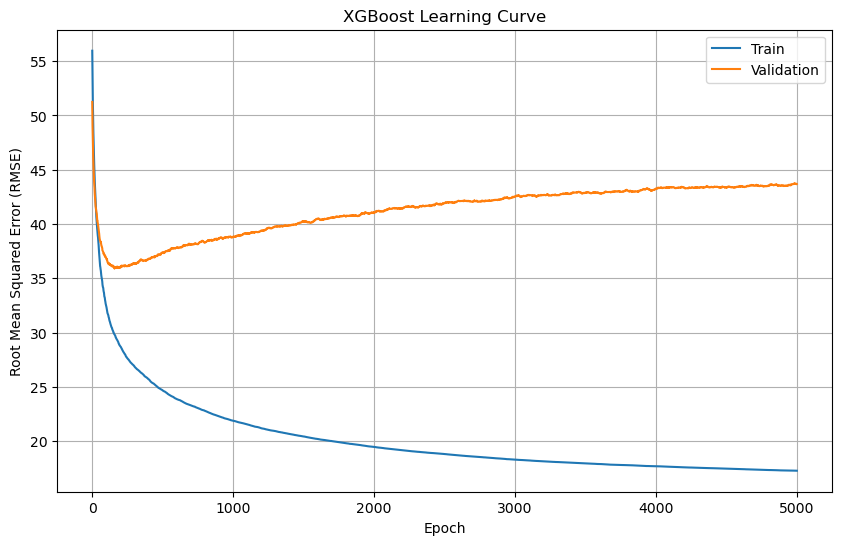

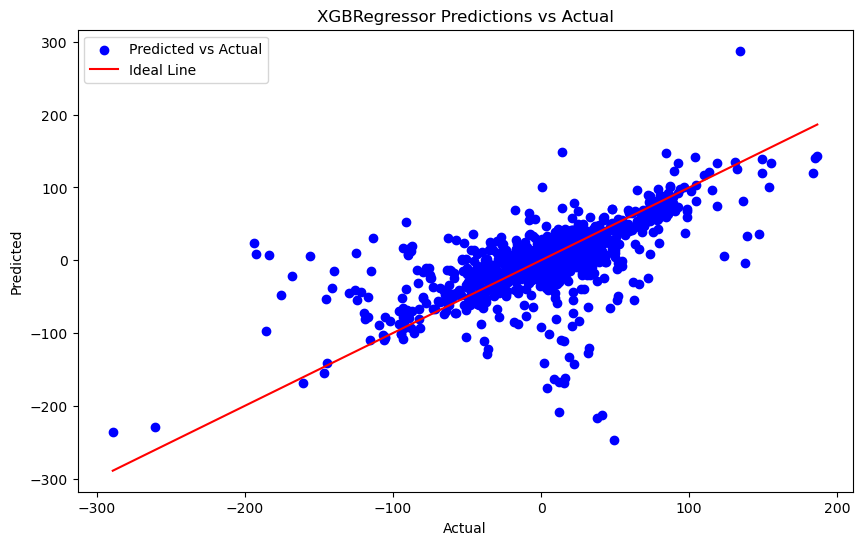

In [ ]:
# Initialize XGBRegressor
model = xgb.XGBRegressor(**xgb_params)

# Train the model using the training data with evaluation set for learning curve
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate and print Root Mean Squared Error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Extract learning curve data
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.title('XGBoost Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.zonal_wind_speed, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test.zonal_wind_speed), max(y_test.zonal_wind_speed)], [min(y_test.zonal_wind_speed), max(y_test.zonal_wind_speed)], color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBRegressor Predictions vs Actual')
plt.legend()
plt.show()

In [ ]:
zonal_winds_may_2024 = zonal_winds[(zonal_winds.datetime >= '2024-05-10') & (zonal_winds.datetime < '2024-05-15')]
zonal_winds_may_2024 = zonal_winds_may_2024.sort_values('datetime')
zonal_winds_may_2024 = zonal_winds_may_2024[['datetime', 'site_name'] + params + ['zonal_wind_speed', 'zws_error']]
zonal_winds_may_2024_cp = zonal_winds_may_2024[zonal_winds_may_2024['site_name']=='caocheira_paulista']
zonal_winds_may_2024_mh = zonal_winds_may_2024[zonal_winds_may_2024['site_name']=='millstone_hill']

In [ ]:
predicted_zw_cp = model.predict(zonal_winds_may_2024_cp[params])
predicted_zw_cp = pd.DataFrame({'datetime': zonal_winds_may_2024_cp['datetime'], 'zonal_wind_speed': predicted_zw_cp})

zonal_winds_may_2024_cp['time_diff'] = zonal_winds_may_2024_cp['datetime'].diff()
zonal_winds_may_2024_cp.loc[zonal_winds_may_2024_cp['time_diff'] > pd.Timedelta(minutes=60), 'zonal_wind_speed'] = np.nan
zonal_winds_may_2024_cp['rolling_avg'] = zonal_winds_may_2024_cp['zonal_wind_speed'].rolling(window=10).mean()

predicted_zw_cp['time_diff'] = predicted_zw_cp['datetime'].diff()
predicted_zw_cp.loc[predicted_zw_cp['time_diff'] > pd.Timedelta(minutes=60), 'zonal_wind_speed'] = np.nan
predicted_zw_cp['rolling_avg'] = predicted_zw_cp['zonal_wind_speed'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/15310587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_cp['time_diff'] = zonal_winds_may_2024_cp['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/15310587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_cp['rolling_avg'] = zonal_winds_may_2024_cp['zonal_wind_speed'].rolling(window=10).mean()


In [ ]:
predicted_zw_mh = model.predict(zonal_winds_may_2024_mh[params])
predicted_zw_mh = pd.DataFrame({'datetime': zonal_winds_may_2024_mh['datetime'], 'zonal_wind_speed': predicted_zw_mh})

zonal_winds_may_2024_mh['time_diff'] = zonal_winds_may_2024_mh['datetime'].diff()
zonal_winds_may_2024_mh.loc[zonal_winds_may_2024_mh['time_diff'] > pd.Timedelta(minutes=60), 'zonal_wind_speed'] = np.nan
zonal_winds_may_2024_mh['rolling_avg'] = zonal_winds_may_2024_mh['zonal_wind_speed'].rolling(window=10).mean()

predicted_zw_mh['time_diff'] = predicted_zw_mh['datetime'].diff()
predicted_zw_mh.loc[predicted_zw_mh['time_diff'] > pd.Timedelta(minutes=60), 'zonal_wind_speed'] = np.nan
predicted_zw_mh['rolling_avg'] = predicted_zw_mh['zonal_wind_speed'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/3101402698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_mh['time_diff'] = zonal_winds_may_2024_mh['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/3101402698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_mh['rolling_avg'] = zonal_winds_may_2024_mh['zonal_wind_speed'].rolling(window=10).mean()


In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime

# Convert the 'datetime' column to datetime type
zonal_winds_may_2024_cp['datetime'] = pd.to_datetime(zonal_winds_may_2024_cp['datetime'], format="%d/%m %H")
predicted_zw_cp['datetime'] = pd.to_datetime(predicted_zw_cp['datetime'], format="%d/%m %H")

# Convert the 'datetime' column to datetime type
zonal_winds_may_2024_mh['datetime'] = pd.to_datetime(zonal_winds_may_2024_mh['datetime'], format="%d/%m %H")
predicted_zw_mh['datetime'] = pd.to_datetime(predicted_zw_mh['datetime'], format="%d/%m %H")

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/4190838069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_cp['datetime'] = pd.to_datetime(zonal_winds_may_2024_cp['datetime'], format="%d/%m %H")
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/4190838069.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_mh['datetime'] = pd.to_datetime(zonal_winds_may_2024_mh['datetime'], format="%d/%m %H")


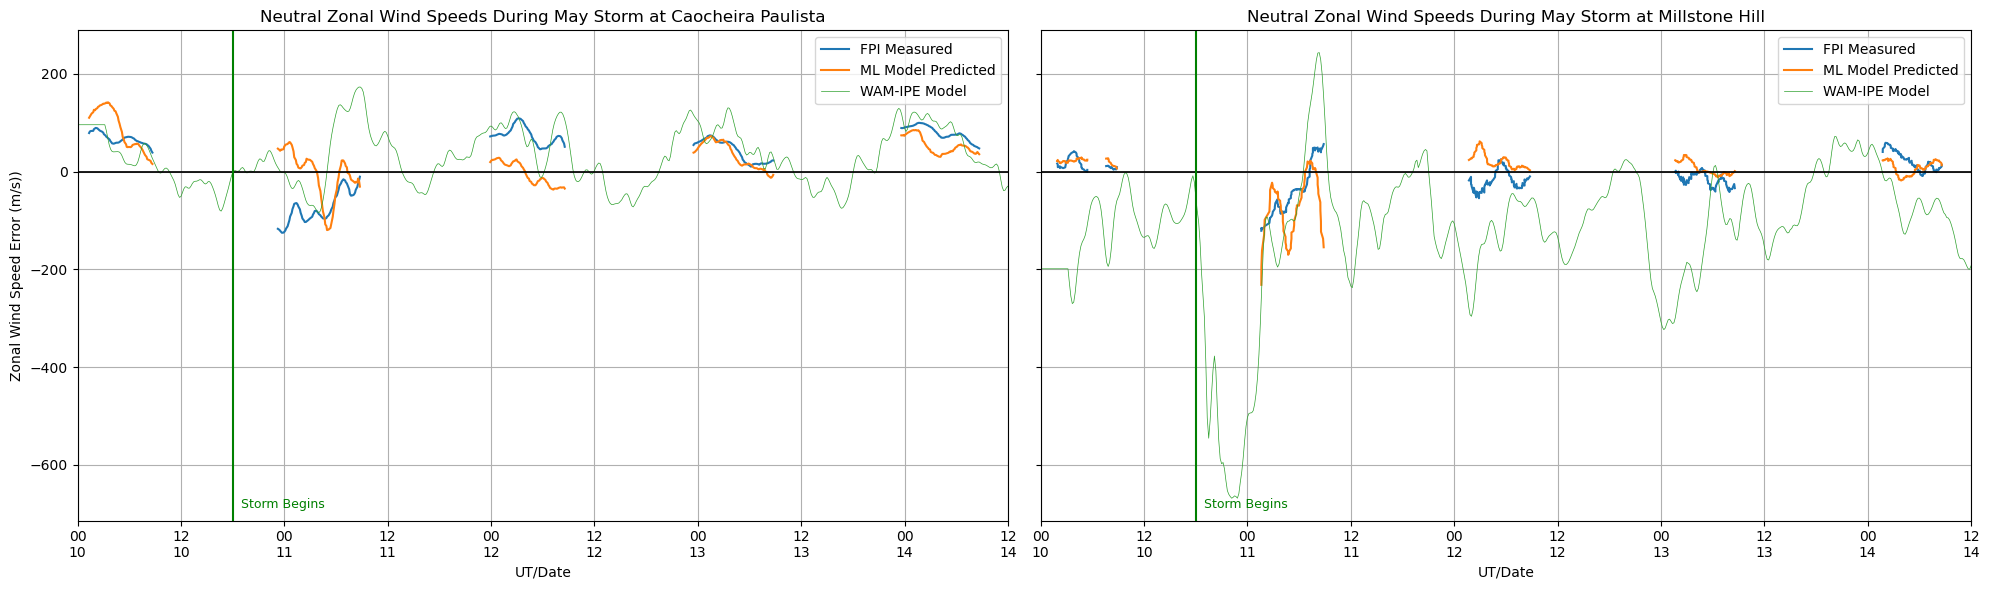

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(zonal_winds_may_2024_cp['datetime'], zonal_winds_may_2024_cp['rolling_avg'], label='FPI Measured')
ax1.plot(predicted_zw_cp['datetime'], predicted_zw_cp['rolling_avg'], label='ML Model Predicted')
ax1.plot(wam_ipe_brazil['datetime'], wam_ipe_brazil['zonal_wind_speed'], label='WAM-IPE Model', linewidth=0.5)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Zonal Wind Speed Error (m/s))')
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax1.set_title('Neutral Zonal Wind Speeds During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(zonal_winds_may_2024_mh['datetime'], zonal_winds_may_2024_mh['rolling_avg'], label='FPI Measured')
ax2.plot(predicted_zw_mh['datetime'], predicted_zw_mh['rolling_avg'], label='ML Model Predicted')
ax2.plot(wam_ipe_millstone_hill['datetime'], wam_ipe_millstone_hill['zonal_wind_speed'], label='WAM-IPE Model', linewidth=0.5)
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax2.set_title('Neutral Zonal Wind Speeds During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Ensure datetime columns are datetime objects
zonal_winds_may_2024_cp['datetime'] = pd.to_datetime(zonal_winds_may_2024_cp['datetime'])
wam_ipe_brazil['datetime'] = pd.to_datetime(wam_ipe_brazil['datetime'])

# Create copies to prevent modifying the original DataFrames
zonal_winds_copy = zonal_winds_may_2024_cp.copy()
wam_ipe_copy = wam_ipe_brazil.copy()

# Set datetime as the index
zonal_winds_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = zonal_winds_copy['rolling_avg'][zonal_winds_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = zonal_winds_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = zonal_winds_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'zonal_wind_speed'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = zonal_winds_copy.index.union(wam_ipe_copy.index)
zonal_winds_resampled = zonal_winds_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = zonal_winds_resampled['rolling_avg'] - wam_ipe_resampled['zonal_wind_speed']

# Create a DataFrame with datetime and difference columns
difference_df_cp = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_cp['datetime'] = pd.to_datetime(difference_df_cp['datetime'])
difference_df_cp['time_diff'] = difference_df_cp['datetime'].diff()
difference_df_cp.loc[difference_df_cp['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_cp = pd.merge(zonal_winds_may_2024_cp[['datetime', 'rolling_avg']],
                     predicted_zw_cp[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_cp['difference'] = merged_df_cp['rolling_avg_measured'] - merged_df_cp['rolling_avg_predicted']

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/258708057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_cp['datetime'] = pd.to_datetime(zonal_winds_may_2024_cp['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/258708057.py:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  zonal_winds_resampled = zonal_winds_copy.reindex(common_index).interpolate()


In [ ]:
# Ensure datetime columns are datetime objects
zonal_winds_may_2024_mh['datetime'] = pd.to_datetime(zonal_winds_may_2024_mh['datetime'])
wam_ipe_millstone_hill['datetime'] = pd.to_datetime(wam_ipe_millstone_hill['datetime'])

# Create copies to prevent modifying the original DataFrames
zonal_winds_copy = zonal_winds_may_2024_mh.copy()
wam_ipe_copy = wam_ipe_millstone_hill.copy()

zonal_winds_copy = zonal_winds_copy.drop_duplicates(subset='datetime')

# Set datetime as the index
zonal_winds_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = zonal_winds_copy['rolling_avg'][zonal_winds_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = zonal_winds_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = zonal_winds_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'zonal_wind_speed'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = zonal_winds_copy.index.union(wam_ipe_copy.index)
zonal_winds_resampled = zonal_winds_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = zonal_winds_resampled['rolling_avg'] - wam_ipe_resampled['zonal_wind_speed']

# Create a DataFrame with datetime and difference columns
difference_df_mh = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_mh['datetime'] = pd.to_datetime(difference_df_mh['datetime'])
difference_df_mh['time_diff'] = difference_df_mh['datetime'].diff()
difference_df_mh.loc[difference_df_mh['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_mh = pd.merge(zonal_winds_may_2024_mh[['datetime', 'rolling_avg']],
                     predicted_zw_mh[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_mh['difference'] = merged_df_mh['rolling_avg_measured'] - merged_df_mh['rolling_avg_predicted']

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/1395464825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_winds_may_2024_mh['datetime'] = pd.to_datetime(zonal_winds_may_2024_mh['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_21834/1395464825.py:34: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  zonal_winds_resampled = zonal_winds_copy.reindex(common_index).interpolate()


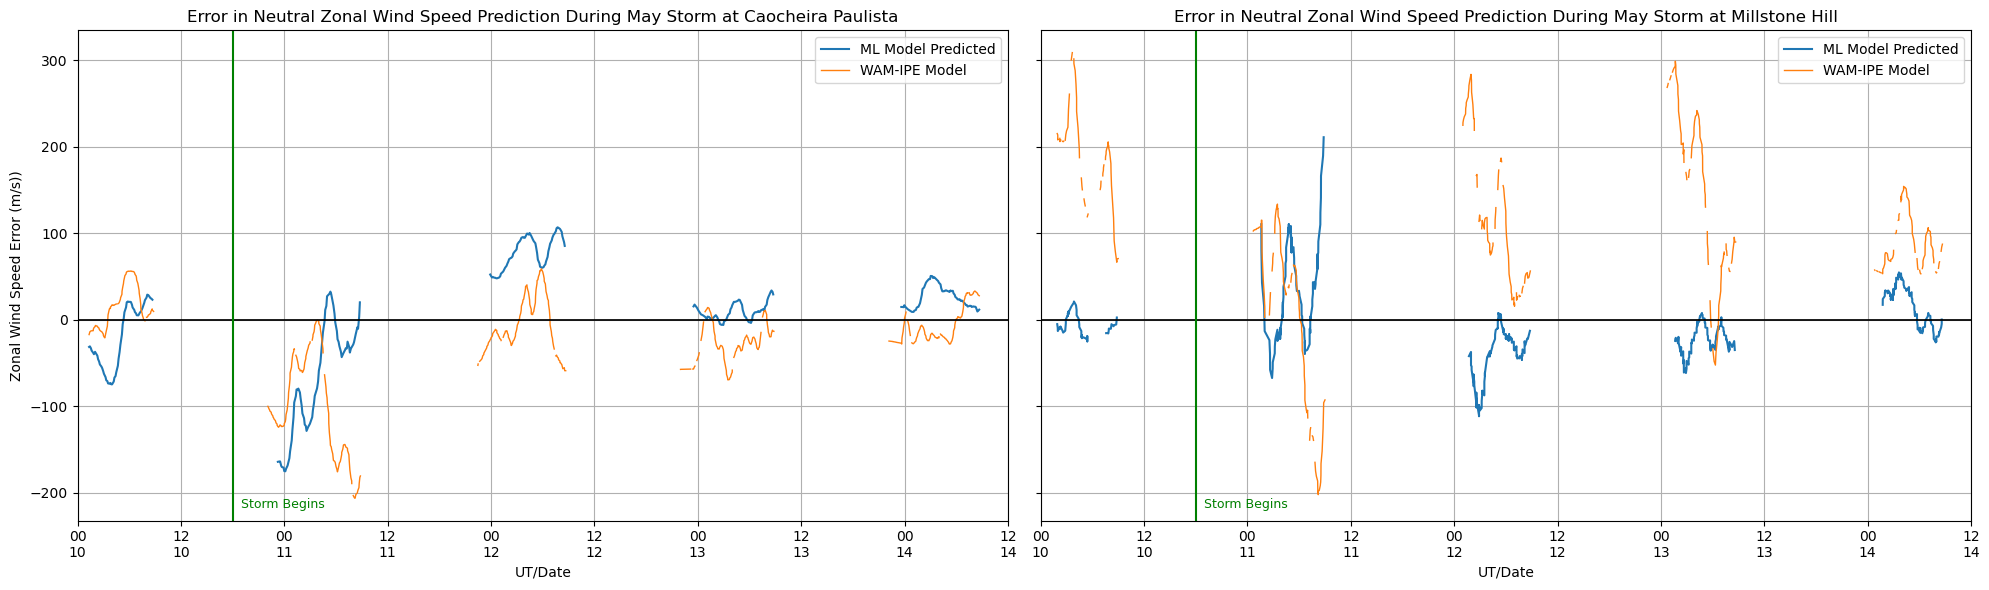

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(merged_df_cp['datetime'], merged_df_cp['difference'], label='ML Model Predicted')
ax1.plot(difference_df_cp['datetime'], difference_df_cp['difference'], label='WAM-IPE Model', linewidth=1)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Zonal Wind Speed Error (m/s))')
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax1.set_title('Error in Neutral Zonal Wind Speed Prediction During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(merged_df_mh['datetime'], merged_df_mh['difference'], label='ML Model Predicted')
ax2.plot(difference_df_mh['datetime'], difference_df_mh['difference'], label='WAM-IPE Model', linewidth=1)
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax2.set_title('Error in Neutral Zonal Wind Speed Prediction During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Training a Specific Meridional Wind Speed Model

In [29]:
import numpy as np

# Splitting into training and testing meridional_windssets
X_train, X_test, y_train, y_test = train_test_split(meridional_winds_params, meridional_winds_target, test_size=0.2, random_state=42)

xgb_params = {
    'objective': 'reg:squarederror',  # For regression task
    'n_estimators': 10000,             # Increase the number of trees (compensate for lower learning rate)
    'learning_rate': 0.1,             # Lower learning rate for finer optimization
    'max_depth': 4,                   # Shallower trees to reduce overfitting
    'subsample': 0.9,                 # Use more data per tree
    'colsample_bytree': 0.9,          # Use more features per tree
    'random_state': 42,               # For reproducibility
    'alpha': 1,                     # L1 regularization
    'lambda': 1,                    # L2 regularization
    'min_child_weight': 5             # Minimum child weight for leaf nodes
}

[0]	validation_0-rmse:53.80085	validation_1-rmse:53.99562
[1]	validation_0-rmse:53.14560	validation_1-rmse:53.34251
[2]	validation_0-rmse:52.61500	validation_1-rmse:52.81131
[3]	validation_0-rmse:52.07557	validation_1-rmse:52.26715
[4]	validation_0-rmse:51.64504	validation_1-rmse:51.83517
[5]	validation_0-rmse:51.28024	validation_1-rmse:51.46666
[6]	validation_0-rmse:50.88829	validation_1-rmse:51.06869
[7]	validation_0-rmse:50.64599	validation_1-rmse:50.82729
[8]	validation_0-rmse:50.34969	validation_1-rmse:50.52803
[9]	validation_0-rmse:50.10921	validation_1-rmse:50.28816
[10]	validation_0-rmse:49.92834	validation_1-rmse:50.10436
[11]	validation_0-rmse:49.71238	validation_1-rmse:49.88197
[12]	validation_0-rmse:49.50975	validation_1-rmse:49.67742
[13]	validation_0-rmse:49.34559	validation_1-rmse:49.51076
[14]	validation_0-rmse:49.21188	validation_1-rmse:49.37718
[15]	validation_0-rmse:49.07556	validation_1-rmse:49.24094
[16]	validation_0-rmse:48.96022	validation_1-rmse:49.12528
[17]	va

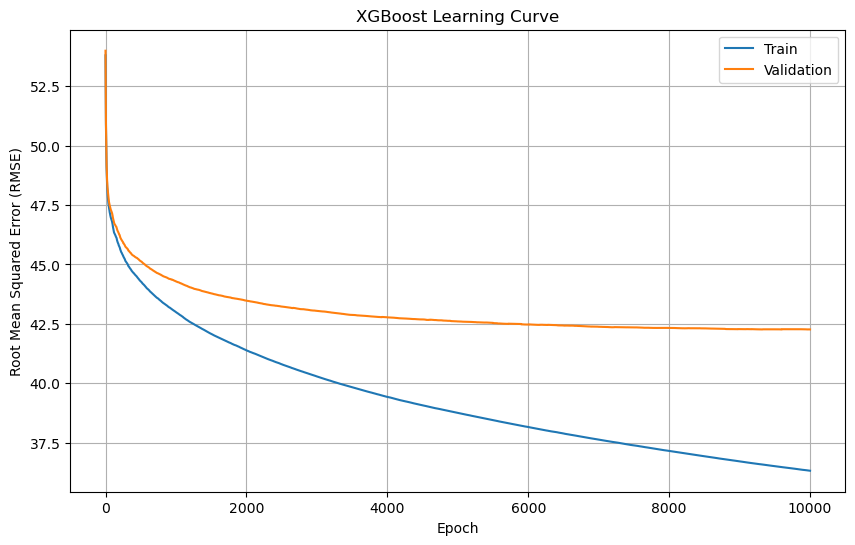

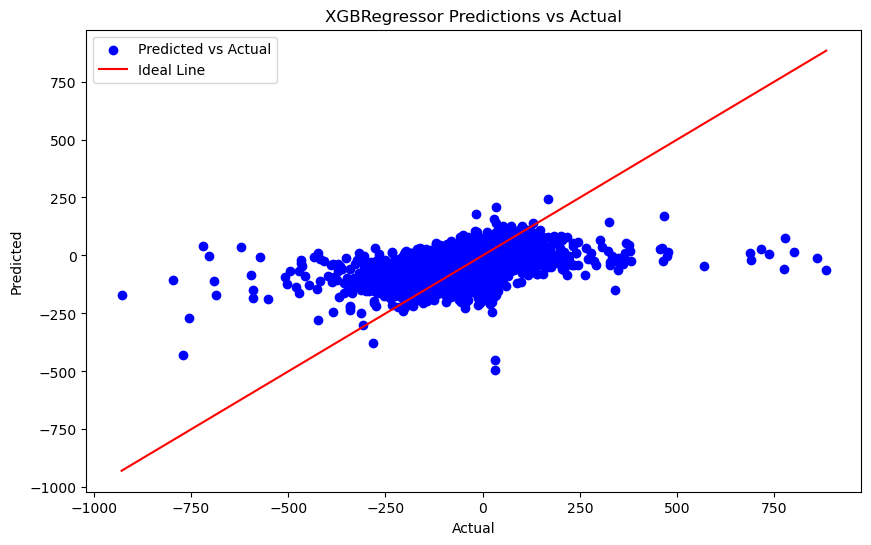

In [30]:
# Initialize XGBRegressor
model = xgb.XGBRegressor(**xgb_params)

# Train the model using the training data with evaluation set for learning curve
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate and print Root Mean Squared Error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Extract learning curve data
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.title('XGBoost Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.meridional_wind_speed, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test.meridional_wind_speed), max(y_test.meridional_wind_speed)], [min(y_test.meridional_wind_speed), max(y_test.meridional_wind_speed)], color='red', label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBRegressor Predictions vs Actual')
plt.legend()
plt.show()

In [31]:
meridional_winds_may_2024 = meridional_winds[(meridional_winds.datetime >= '2024-05-10') & (meridional_winds.datetime < '2024-05-15')]
meridional_winds_may_2024 = meridional_winds_may_2024.sort_values('datetime')
meridional_winds_may_2024 = meridional_winds_may_2024[['datetime', 'site_name'] + params + ['meridional_wind_speed', 'mws_error']]
meridional_winds_may_2024_cp = meridional_winds_may_2024[meridional_winds_may_2024['site_name']=='caocheira_paulista']
meridional_winds_may_2024_mh = meridional_winds_may_2024[meridional_winds_may_2024['site_name']=='millstone_hill']

In [32]:
predicted_mw_cp = model.predict(meridional_winds_may_2024_cp[params])
predicted_mw_cp = pd.DataFrame({'datetime': meridional_winds_may_2024_cp['datetime'], 'meridional_wind_speed': predicted_mw_cp})

meridional_winds_may_2024_cp['time_diff'] = meridional_winds_may_2024_cp['datetime'].diff()
meridional_winds_may_2024_cp.loc[meridional_winds_may_2024_cp['time_diff'] > pd.Timedelta(minutes=60), 'meridional_wind_speed'] = np.nan
meridional_winds_may_2024_cp['rolling_avg'] = meridional_winds_may_2024_cp['meridional_wind_speed'].rolling(window=10).mean()

predicted_mw_cp['time_diff'] = predicted_mw_cp['datetime'].diff()
predicted_mw_cp.loc[predicted_mw_cp['time_diff'] > pd.Timedelta(minutes=60), 'meridional_wind_speed'] = np.nan
predicted_mw_cp['rolling_avg'] = predicted_mw_cp['meridional_wind_speed'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2949839647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_cp['time_diff'] = meridional_winds_may_2024_cp['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2949839647.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_cp['rolling_avg'] = meridional_winds_may_2024_cp['meridional_wind_speed'].rolling(window=10).mean()


In [33]:
predicted_mw_mh = model.predict(meridional_winds_may_2024_mh[params])
predicted_mw_mh = pd.DataFrame({'datetime': meridional_winds_may_2024_mh['datetime'], 'meridional_wind_speed': predicted_mw_mh})

meridional_winds_may_2024_mh['time_diff'] = meridional_winds_may_2024_mh['datetime'].diff()
meridional_winds_may_2024_mh.loc[meridional_winds_may_2024_mh['time_diff'] > pd.Timedelta(minutes=60), 'meridional_wind_speed'] = np.nan
meridional_winds_may_2024_mh['rolling_avg'] = meridional_winds_may_2024_mh['meridional_wind_speed'].rolling(window=10).mean()

predicted_mw_mh['time_diff'] = predicted_mw_mh['datetime'].diff()
predicted_mw_mh.loc[predicted_mw_mh['time_diff'] > pd.Timedelta(minutes=60), 'meridional_wind_speed'] = np.nan
predicted_mw_mh['rolling_avg'] = predicted_mw_mh['meridional_wind_speed'].rolling(window=10).mean()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/191735845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_mh['time_diff'] = meridional_winds_may_2024_mh['datetime'].diff()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/191735845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_mh['rolling_avg'] = meridional_winds_may_2024_mh['meridional_wind_speed'].rolling(window=10).mean()


In [34]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime

# Convert the 'datetime' column to datetime type
meridional_winds_may_2024_cp['datetime'] = pd.to_datetime(meridional_winds_may_2024_cp['datetime'], format="%d/%m %H")
predicted_mw_cp['datetime'] = pd.to_datetime(predicted_mw_cp['datetime'], format="%d/%m %H")

# Convert the 'datetime' column to datetime type
meridional_winds_may_2024_mh['datetime'] = pd.to_datetime(meridional_winds_may_2024_mh['datetime'], format="%d/%m %H")
predicted_mw_mh['datetime'] = pd.to_datetime(predicted_mw_mh['datetime'], format="%d/%m %H")

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3843766857.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_cp['datetime'] = pd.to_datetime(meridional_winds_may_2024_cp['datetime'], format="%d/%m %H")
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/3843766857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_mh['datetime'] = pd.to_datetime(meridional_winds_may_2024_mh['datetime'], format="%d/%m %H")


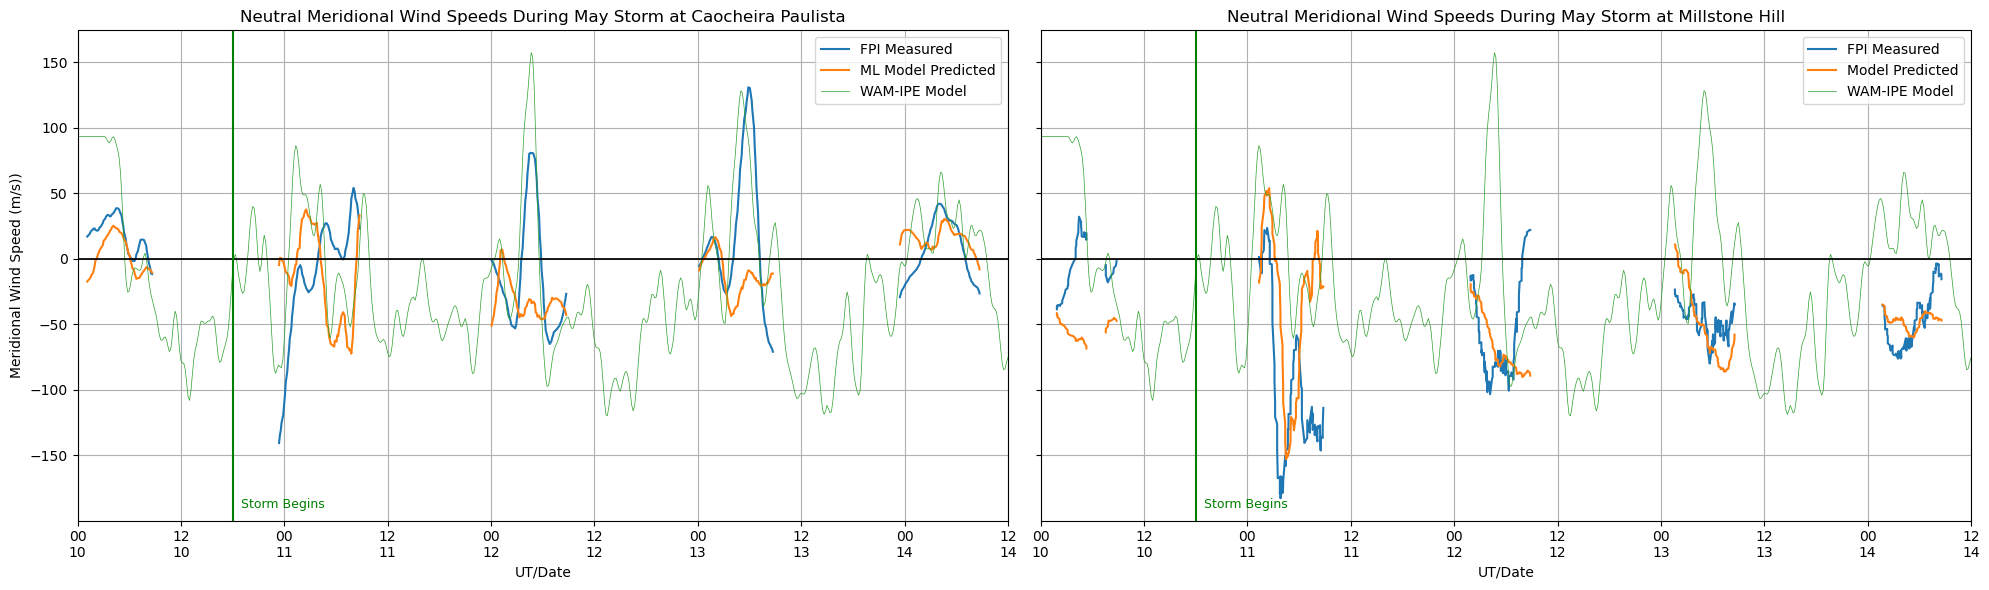

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(meridional_winds_may_2024_cp['datetime'], meridional_winds_may_2024_cp['rolling_avg'], label='FPI Measured')
ax1.plot(predicted_mw_cp['datetime'], predicted_mw_cp['rolling_avg'], label='ML Model Predicted')
ax1.plot(wam_ipe_brazil['datetime'], wam_ipe_brazil['meridional_wind_speed'], label='WAM-IPE Model', linewidth=0.5)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Meridional Wind Speed (m/s))')
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax1.set_title('Neutral Meridional Wind Speeds During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(meridional_winds_may_2024_mh['datetime'], meridional_winds_may_2024_mh['rolling_avg'], label='FPI Measured')
ax2.plot(predicted_mw_mh['datetime'], predicted_mw_mh['rolling_avg'], label='Model Predicted')
ax2.plot(wam_ipe_brazil['datetime'], wam_ipe_brazil['meridional_wind_speed'], label='WAM-IPE Model', linewidth=0.5)
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax2.set_title('Neutral Meridional Wind Speeds During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Ensure datetime columns are datetime objects
meridional_winds_may_2024_cp['datetime'] = pd.to_datetime(meridional_winds_may_2024_cp['datetime'])
wam_ipe_brazil['datetime'] = pd.to_datetime(wam_ipe_brazil['datetime'])

# Create copies to prevent modifying the original DataFrames
meridional_winds_copy = meridional_winds_may_2024_cp.copy()
wam_ipe_copy = wam_ipe_brazil.copy()

# Set datetime as the index
meridional_winds_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = meridional_winds_copy['rolling_avg'][meridional_winds_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = meridional_winds_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = meridional_winds_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'meridional_wind_speed'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = meridional_winds_copy.index.union(wam_ipe_copy.index)
meridional_winds_resampled = meridional_winds_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = meridional_winds_resampled['rolling_avg'] - wam_ipe_resampled['meridional_wind_speed']

# Create a DataFrame with datetime and difference columns
difference_df_cp = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_cp['datetime'] = pd.to_datetime(difference_df_cp['datetime'])
difference_df_cp['time_diff'] = difference_df_cp['datetime'].diff()
difference_df_cp.loc[difference_df_cp['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_cp = pd.merge(meridional_winds_may_2024_cp[['datetime', 'rolling_avg']],
                     predicted_mw_cp[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_cp['difference'] = merged_df_cp['rolling_avg_measured'] - merged_df_cp['rolling_avg_predicted']

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/4013527962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_cp['datetime'] = pd.to_datetime(meridional_winds_may_2024_cp['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/4013527962.py:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  meridional_winds_resampled = meridional_winds_copy.reindex(common_index).interpolate()


In [37]:
# Ensure datetime columns are datetime objects
meridional_winds_may_2024_mh['datetime'] = pd.to_datetime(meridional_winds_may_2024_mh['datetime'])
wam_ipe_millstone_hill['datetime'] = pd.to_datetime(wam_ipe_millstone_hill['datetime'])

# Create copies to prevent modifying the original DataFrames
meridional_winds_copy = meridional_winds_may_2024_mh.copy()
wam_ipe_copy = wam_ipe_millstone_hill.copy()

meridional_winds_copy = meridional_winds_copy.drop_duplicates(subset='datetime')

# Set datetime as the index
meridional_winds_copy.set_index('datetime', inplace=True)
wam_ipe_copy.set_index('datetime', inplace=True)

# Identify `NaN` values in rolling_avg and their indices
nan_indices = meridional_winds_copy['rolling_avg'][meridional_winds_copy['rolling_avg'].isna()].index

# Process each NaN value in rolling_avg column
for nan_time in nan_indices:
    # Find the closest datetime before and after the NaN
    previous_time = meridional_winds_copy['rolling_avg'][:nan_time].last_valid_index()
    next_time = meridional_winds_copy['rolling_avg'][nan_time:].first_valid_index()

    if previous_time is not None and next_time is not None:
        # Filter out rows in wam_ipe_copy between these times
        mask = (wam_ipe_copy.index > previous_time) & (wam_ipe_copy.index < next_time)
        wam_ipe_copy.loc[mask, 'meridional_wind_speed'] = np.nan

# Ensure DataFrame remains sorted after adding rows
wam_ipe_copy.sort_index(inplace=True)

# Reindex to a common datetime index (union of indices)
common_index = meridional_winds_copy.index.union(wam_ipe_copy.index)
meridional_winds_resampled = meridional_winds_copy.reindex(common_index).interpolate()
wam_ipe_resampled = wam_ipe_copy.reindex(common_index).interpolate()

# Calculate the difference
difference = meridional_winds_resampled['rolling_avg'] - wam_ipe_resampled['meridional_wind_speed']

# Create a DataFrame with datetime and difference columns
difference_df_mh = pd.DataFrame({
    'datetime': difference.index,
    'difference': difference
})

difference_df_mh['datetime'] = pd.to_datetime(difference_df_mh['datetime'])
difference_df_mh['time_diff'] = difference_df_mh['datetime'].diff()
difference_df_mh.loc[difference_df_mh['time_diff'] > pd.Timedelta(minutes=9.99), 'difference'] = np.nan


# Merge the two dataframes based on 'datetime' column
merged_df_mh = pd.merge(meridional_winds_may_2024_mh[['datetime', 'rolling_avg']],
                     predicted_mw_mh[['datetime', 'rolling_avg']],
                     on='datetime', 
                     suffixes=('_measured', '_predicted'))

# Calculate the difference between the rolling_avg columns
merged_df_mh['difference'] = merged_df_mh['rolling_avg_measured'] - merged_df_mh['rolling_avg_predicted']

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2505280411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meridional_winds_may_2024_mh['datetime'] = pd.to_datetime(meridional_winds_may_2024_mh['datetime'])
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_24618/2505280411.py:34: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  meridional_winds_resampled = meridional_winds_copy.reindex(common_index).interpolate()


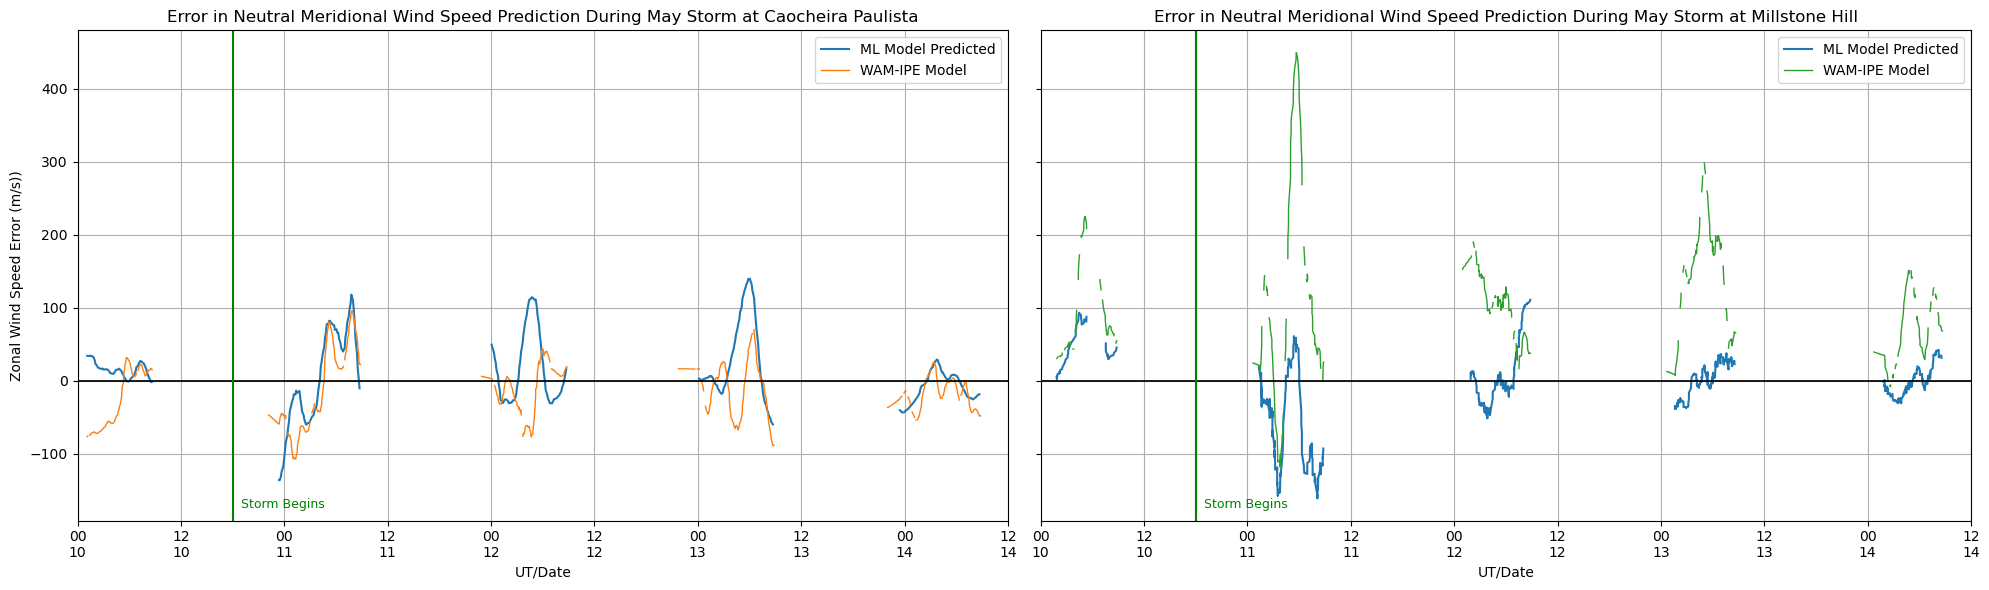

In [41]:
# Create a figure with 2 adjacent subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define x-axis limits
xmin = pd.to_datetime("2024-05-10 00:00:00")
xmax = pd.to_datetime("2024-05-14 12:00:00")

# Plot on the first subplot (ax1)
ax1.plot(merged_df_cp['datetime'], merged_df_cp['difference'], label='ML Model Predicted')
ax1.plot(difference_df_cp['datetime'], difference_df_cp['difference'], label='WAM-IPE Model', linewidth=1)
ax1.grid()
ax1.set_xlabel('UT/Date')
ax1.set_ylabel('Zonal Wind Speed Error (m/s))')
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax1.legend()
ax1.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax1.set_title('Error in Neutral Meridional Wind Speed Prediction During May Storm at Caocheira Paulista')

# Plot on the second subplot (ax2)
ax2.plot(merged_df_mh['datetime'], merged_df_mh['difference'], label='ML Model Predicted')
ax2.plot(difference_df_mh['datetime'], difference_df_mh['difference'], label='WAM-IPE Model', linewidth=1, color='#2ca02c')
ax2.grid()
ax2.set_xlabel('UT/Date')
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%d'))  # Format the x-axis labels
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Hour locator with 12-hour intervals
ax2.legend()
ax2.axhline(0, color='black', linestyle='-', linewidth=1.25)
ax2.set_title('Error in Neutral Meridional Wind Speed Prediction During May Storm at Millstone Hill')

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax2.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax2.text(storm_time_utc + pd.Timedelta(hours=1), ((ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.025) + ax2.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Mark the storm time
storm_time_utc = datetime.strptime('2024-05-10 18:00', "%Y-%m-%d %H:%M")
ax1.axvline(storm_time_utc, color='green', linestyle='-', linewidth=1.5)
ax1.text(storm_time_utc + pd.Timedelta(hours=1), ((ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.025) + ax1.get_ylim()[0], 'Storm Begins', color='green', fontsize=9)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()